# Classification using Attention-based Deep Multiple Instance Learning (MIL).
### 基于注意力机制的多示例学习

原文链接：https://keras.io/examples/vision/attention_mil_classification/

## Note：  

这是多示例学习中非常简单且易懂的例子，代码短小精悍并且有很多注释，能让没接触过的人也可以快速了解多示例学习的步骤。  

简单来说多示例学习的需求背景是：数据集是由“包”（bag）组成，每个包中元素个数不确定，只要目标元素在某个包中就是 “正包”，反之为 “负包”。在下面例子中，假设元素 “1” 是目标元素，那么正负包分别为：  

```python
a = [1,2,3,4,5]     正包
b = [0,1,0,1]       正包
c = [9,7,8,6]       负包
d = []              负包
```

此处非常推荐知乎博主 “新元”的博客 [Multi-Instance Learning（多示例学习）](https://zhuanlan.zhihu.com/p/438169271)作为最简单的概念入门。  


至此，有人可能会问：为啥不直接扫描每个包然后判断其存在与否将包分为正负样本呢？而且即便是多示例学习也是需要对每个包进行计算的，这两者有什么区别？  

如果能提出这个问题，说明你善于思考。确实，多示例学习的确需要对每个包进行扫描，但上面的例子仅仅是这个框架的一个入门介绍。实际上多示例学习最初的应用背景是在药物上。  

药物分子依附在蛋白质上才会起作用，一个蛋白质有多个位点可以吸附多种蛋白，假设现在有四种药物ABCD吸附在蛋白质展开而成的肽链上，列出以下几种可能的吸附情况：
```python
AAABCDA     有效
CAABCDACB   有效
DABCBAACB   无效
BCBAADCB    有效
```
从上面能够发现貌似只要包含两个及两个以上的 “AA” 就可以使得药物有效，但第三个样本中却无效，貌似没有一个特别明显的判断方案。这才是多示例学习需要解决的问题，因为在上述案例中包内元素的有无和位置都会决定这个包是一个正包还是一个负包。  

下面这个图来自于图像多示例学习的经典论文 [Multiple Instance Learning Convolutional Neural Networks for Object Recognition](extension://bfdogplmndidlpjfhoijckpakkdjkkil/pdf/viewer.html?file=https%3A%2F%2Farxiv.org%2Fpdf%2F1610.03155.pdf) （2016）.

<img src='../images/CV_Img/MILsample.png'>  

将图像拆成多个小块，然后判断每个小块中包含的核心元素是什么。第一张图以灰蝶（Lycaenid）为判断依据，第二张图则以乒乓球（Ping-pong ball）为依据。根据核心元素的存在与否来实现图像分类任务。  

从这个图像分类多示例中能发现一股 ViT（2020） 的味道，也许Vit在构建的时候也参考了这篇文章的思想。

--------------

## Introduction
### What is Multiple Instance Learning (MIL)?
Usually, with supervised learning algorithms, the learner receives labels for a set of instances. In the case of MIL, the learner receives labels for a set of bags, each of which contains a set of instances. The bag is labeled positive if it contains at least one positive instance, and negative if it does not contain any.  
通常，在监督学习任务中使用的是一组有实例的标签。而在多示例下，会受到一组包的标签，每个包都包含一组实例。如果一个包中至少存在一个正实例，那么该包则为正样本；如果包不含任何实例，那么该包则为负样本。

### Motivation
It is often assumed in image classification tasks that each image clearly represents a class label. In medical imaging (e.g. computational pathology, etc.) an entire image is represented by a single class label (cancerous/non-cancerous) or a region of interest could be given. However, one will be interested in knowing which patterns in the image is actually causing it to belong to that class. In this context, the image(s) will be divided and the subimages will form the bag of instances.  
在图像分类任务中，通常假设每张图像清楚地代表一个类别标签。在医学影像中，整个图像由单个类别标签（癌/非癌）表示，或者框出感兴趣的区域。但是，人们会思考图像中的哪些内容决定了该图所属的类别，在这种情况下，将图像分割成子图，由子图形成实例包。  

此时，目标变成：  
1. 训练一个模型来预测一个包的标签。
2. 找出包中哪些实例作用于标签预测。

### Implementation
以下步骤描述了模型的工作原理：  
1. 特征提取器抽取特征。
2. 特征被输入MIL注意力层以获得注意力分数，同时该层是 **permutation-invariant** （置换不变），即调整输入顺序结果保持不变。
3. 特征和注意力分数相乘。
4. 输出结构传递给softmax进行分类。

### References
* [Attention-based Deep Multiple Instance Learning.](https://arxiv.org/abs/1802.04712)
* Some of the attention operator code implementation was inspired from https://github.com/utayao/Atten_Deep_MIL.
* Imbalanced data [tutorial](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data) by TensorFlow.

-------------

## Step

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
from matplotlib import pyplot as plt

----------

## Create dataset
We will create a set of bags and assign their labels according to their contents. If at least one positive instance is available in a bag, the bag is considered as a positive bag. If it does not contain any positive instance, the bag will be considered as negative.  
创建一组bag并根据其中内容分配标签。如果包中至少有一个正样本则该包为正包，否则为负包。

### Configuration parameters
* POSITIVE_CLASS: 正包中的实例类。
* BAG_COUNT: 训练集的包数。
* VAL_BAG_COUNT: 验证集的包数。
* BAG_SIZE: 每个包的实例个数。
* PLOT_SIZE: 绘图时展示的包数。
* ENSEMBLE_AVG_COUNT: 平均需要创建的模型数量。(如果只需要一个模型则设置为1)

In [2]:
POSITIVE_CLASS = 1  # 在此处就是数字为“1”的图像，如果修改为2则为包含“2”的实例为正包
BAG_COUNT = 1000
VAL_BAG_COUNT = 300
BAG_SIZE = 3
PLOT_SIZE = 3
ENSEMBLE_AVG_COUNT = 1

### Prepare bags
Since the attention operator is a permutation-invariant operator, an instance with a positive class label is randomly placed among the instances in the positive bag.  
由于注意力算子是一个置换不变的算子，将一个正标签的实例随机放在包中触发包的正标签。

In [3]:
def create_bags(input_data, input_labels, positive_class, bag_count, instance_count):
    bags = []
    bag_labels = []
    # 标准化输入
    input_data = np.divide(input_data, 255.0)
    # 正包数
    count = 0

    for _ in range(bag_count):
        # 选择一个固定大小的随机样本子集
        index = np.random.choice(input_data.shape[0], instance_count, replace=False)
        instances_data = input_data[index]
        instances_labels = input_labels[index]

        # 初始时所有包的标签都为负（0）
        bag_label = 0
        # 检查包中是否包含至少一个正样本
        if positive_class in instances_labels:
            # 存在则将包标签改为正（1）
            bag_label = 1
            count += 1
        bags.append(instances_data)
        bag_labels.append(np.array([bag_label]))

    print(f"Positive bags: {count}")
    print(f"Negative bags: {bag_count - count}")
    return (list(np.swapaxes(bags, 0, 1)), np.array(bag_labels))

In [4]:
# 使用MNIST数据集
(x_train, y_train), (x_val, y_val) = keras.datasets.mnist.load_data()
# 创造训练集
train_data, train_labels = create_bags(
    x_train, y_train, POSITIVE_CLASS, BAG_COUNT, BAG_SIZE
)
# 创造验证集
val_data, val_labels = create_bags(
    x_val, y_val, POSITIVE_CLASS, VAL_BAG_COUNT, BAG_SIZE
)

Positive bags: 337
Negative bags: 663
Positive bags: 79
Negative bags: 221


---------------

## Create the model
We will now build the attention layer, prepare some utilities, then build and train the entire model.  
搭建注意力层、准备一些辅助函数、构建和训练模型。


### Attention operator implementation 注意力算子的实现
The output size of this layer is decided by the size of a single bag.  
该层的输出大小由单个包的大小决定。  

The attention mechanism uses a weighted average of instances in a bag, in which the sum of the weights must equal to 1 (invariant of the bag size).  
注意力机制使用包中实例（特征）的加权平均值，其中权重和必须等于1（固定包大小）。  

The weight matrices (parameters) are w and v. To include positive and negative values, hyperbolic tangent element-wise non-linearity is utilized.  
权重矩阵是w和v。为了让权重的值域能够包含正负值，使用双曲正切函数（tanh）作为激活函数。  

A Gated attention mechanism can be used to deal with complex relations. Another weight matrix, u, is added to the computation. A sigmoid non-linearity is used to overcome approximately linear behavior for x ∈ [−1, 1] by hyperbolic tangent non-linearity.  
门控注意力机制能够用于处理复杂的对应关系。引入另一个权重矩阵u。使用sigmoid函数将tanh输出值控制在 [-1, 1]之内。

In [5]:
class MILAttentionLayer(layers.Layer):
    """Implementation of the attention-based Deep MIL layer.

    Args:
      weight_params_dim: 正整数，权重矩阵w的维度。
      kernel_initializer: 核初始化方案。
      kernel_regularizer: 核正则化方案。
      use_gated: 布尔值，控制是否使用门控机制。

    Returns:
      List of 2D tensors with BAG_SIZE length. 
      一个BAG_SIZE大小的二维张量列表。
      The tensors are the attention scores after softmax with shape `(batch_size, 1)`.
      该张量是经过softmax之后的注意力分数，shape=(batch_size,1)
    """

    def __init__(
        self,
        weight_params_dim,
        kernel_initializer="glorot_uniform",
        kernel_regularizer=None,
        use_gated=False,
        **kwargs,
    ):

        super().__init__(**kwargs)

        self.weight_params_dim = weight_params_dim
        self.use_gated = use_gated

        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)

        self.v_init = self.kernel_initializer
        self.w_init = self.kernel_initializer
        self.u_init = self.kernel_initializer

        self.v_regularizer = self.kernel_regularizer
        self.w_regularizer = self.kernel_regularizer
        self.u_regularizer = self.kernel_regularizer

    def build(self, input_shape):  # shape=(batch_size, input_dim)
        input_dim = input_shape[0][1]

        self.v_weight_params = self.add_weight(
            shape=(input_dim, self.weight_params_dim),
            initializer=self.v_init,
            name="v",
            regularizer=self.v_regularizer,
            trainable=True,
        )

        self.w_weight_params = self.add_weight(
            shape=(self.weight_params_dim, 1),
            initializer=self.w_init,
            name="w",
            regularizer=self.w_regularizer,
            trainable=True,
        )

        if self.use_gated:
            self.u_weight_params = self.add_weight(
                shape=(input_dim, self.weight_params_dim),
                initializer=self.u_init,
                name="u",
                regularizer=self.u_regularizer,
                trainable=True,
            )
        else:
            self.u_weight_params = None

        self.input_built = True

    def call(self, inputs):
        # Assigning variables from the number of inputs. 根据输入的大小分配数量
        instances = [self.compute_attention_scores(instance) for instance in inputs]
        # 使用softmax将总和控制在1
        alpha = tf.math.softmax(instances, axis=0)
        return [alpha[i] for i in range(alpha.shape[0])]

    def compute_attention_scores(self, instance):
        original_instance = instance
        # tanh(v*h_k^T)
        instance = tf.math.tanh(tf.tensordot(instance, self.v_weight_params, axes=1))
        # 门控机制用于学习非线性关系
        if self.use_gated:
            instance = instance * tf.math.sigmoid(
                tf.tensordot(original_instance, self.u_weight_params, axes=1)
            )
        # w^T*(tanh(v*h_k^T)) / w^T*(tanh(v*h_k^T)*sigmoid(u*h_k^T))
        return tf.tensordot(instance, self.w_weight_params, axes=1)

--------

## Visualizer tool

In [6]:
def plot(data, labels, bag_class, predictions=None, attention_weights=None):
    """"Utility for plotting bags and attention weights.

    Args:
      data: 包输入。
      labels: 包对应的标签。
      bag_class: 包类别，仅限“正包”、“负包”。
      predictions: 模型预测结果。如果不指定内容，则直接使用 labels 的值。
      attention_weights: 包中每个实例的注意力权重。如果不指定内容，则不会显示。
    """

    labels = np.array(labels).reshape(-1)

    if bag_class == "positive":
        if predictions is not None:
            labels = np.where(predictions.argmax(1) == 1)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]

        else:
            labels = np.where(labels == 1)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]

    elif bag_class == "negative":
        if predictions is not None:
            labels = np.where(predictions.argmax(1) == 0)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]
        else:
            labels = np.where(labels == 0)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]

    else:
        print(f"There is no class {bag_class}")
        return

    print(f"The bag class label is {bag_class}")
    for i in range(PLOT_SIZE):
        figure = plt.figure(figsize=(8, 8))
        print(f"Bag number: {labels[i]}")
        for j in range(BAG_SIZE):
            image = bags[j][i]
            figure.add_subplot(1, BAG_SIZE, j + 1)
            plt.grid(False)
            if attention_weights is not None:
                plt.title(np.around(attention_weights[labels[i]][j], 2))
            plt.imshow(image)
        plt.show()

The bag class label is positive
Bag number: 2


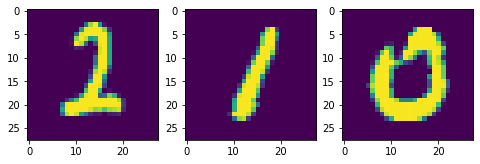

Bag number: 6


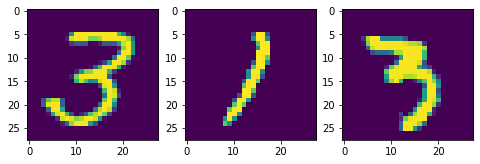

Bag number: 7


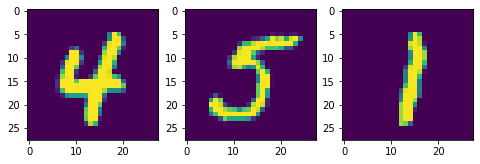

The bag class label is negative
Bag number: 0


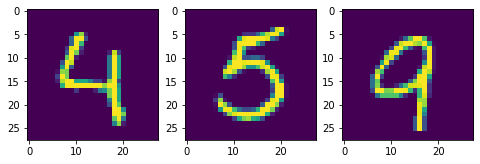

Bag number: 1


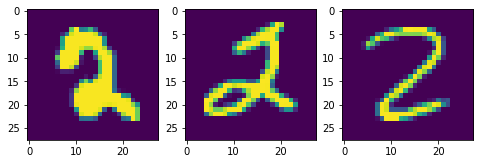

Bag number: 3


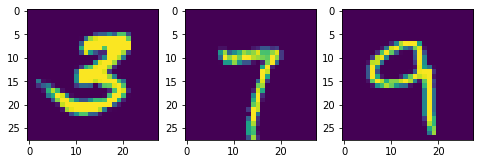

In [7]:
plot(val_data, val_labels, "positive")
plot(val_data, val_labels, "negative")

------------

## Create model

In [8]:
def create_model(instance_shape):

    # 从输入中抽取特征
    inputs, embeddings = [], []
    shared_dense_layer_1 = layers.Dense(128, activation="relu")
    shared_dense_layer_2 = layers.Dense(64, activation="relu")
    for _ in range(BAG_SIZE):
        inp = layers.Input(instance_shape)
        flatten = layers.Flatten()(inp)
        dense_1 = shared_dense_layer_1(flatten)
        dense_2 = shared_dense_layer_2(dense_1)
        inputs.append(inp)
        embeddings.append(dense_2)

    # 调用注意力层
    alpha = MILAttentionLayer(
        weight_params_dim=256,
        kernel_regularizer=keras.regularizers.l2(0.01),
        use_gated=True,
        name="alpha",
    )(embeddings)

    # 将注意力权重和输入相乘
    multiply_layers = [
        layers.multiply([alpha[i], embeddings[i]]) for i in range(len(alpha))
    ]

    # 串联层
    concat = layers.concatenate(multiply_layers, axis=1)
    # 模型分类
    output = layers.Dense(2, activation="softmax")(concat)
    return keras.Model(inputs, output)

-----------

## Class weights
Since this kind of problem could simply turn into imbalanced data classification problem, class weighting should be considered.  
由于这类问题往往数据不平衡（上面代码中正包数量要小于负包），因此需要考虑正负类的权重。  

Let's say there are 1000 bags. There often could be cases were 90 % of the bags do not contain any positive label and ~10 % do. Such data can be referred to as Imbalanced data.  
假设有1000个包。通常情况下约90%的包不含正样本（负包），而10%的包为正包。这就是数据不平衡 **Imbalanced data**。  

Using class weights, the model will tend to give a higher weight to the rare class.  
对于这类问题，模型要赋予少数类更高的权重。  

### 数据不平衡的后果
对于权重不平衡的数据会有什么影响以及如何因对，知乎博主 **起什么名字好呢** 的一篇博客 [机器学习中的非均衡问题(imbalanced data)和应对方法](https://zhuanlan.zhihu.com/p/38687978) 进行了详细的解释，非常值得阅读。  

他以一个 “银行信用卡异常” 案例进行了通俗解释，此处对其进行概述。  

假设一个银行有 98% 是正常业务，有 2% 是盗刷。如果模型不考虑非均匀的话，默认是最大化准确率（Accuracy）进行训练的，那么只要模型将所有输入全标记为正常业务就可以在最短的时间内达到 98% 的分类准确率，大部分人看到这么高的准确率就会停止训练，导致的后果就是代价不对等。比如正常业务每笔赚2元手续费，而成功盗刷一笔5000元就会让银行损失对等金额，为了挽回一笔盗刷则需要2500笔正常交易，这个比例远高于 98:2。  

通常情况下当样本比例超过 **4:1** 时，就可以认为数据不平衡 **Imbalanced data**。

### 如何解决
根据该博客提供的方法，至少可以使用以下手段解决数据不平衡：
* [Kappa指数](https://thedatascientist.com/performance-measures-cohens-kappa-statistic/)
* [ROC](https://machinelearningmastery.com/assessing-comparing-classifier-performance-roc-curves-2/)
* [F-Scoure](https://en.wikipedia.org/wiki/F-score)
* [Precision and Recall](https://zhuanlan.zhihu.com/p/101101207)

在这个博客中使用的是权重调整，这个方法在简单问题上是可以的，但一定要清楚使用这个方法进行权重重调整十分依赖经验，如果遇到复杂问题还是优先考虑上面的方法。

In [9]:
def compute_class_weights(labels):
    # 统计正负包数量
    negative_count = len(np.where(labels == 0)[0])
    positive_count = len(np.where(labels == 1)[0])
    total_count = negative_count + positive_count

    # 构建权重值
    return {
        0: (1 / negative_count) * (total_count / 2),
        1: (1 / positive_count) * (total_count / 2),
    }

----------

## Build and train model

In [10]:
import os

if not os.path.exists('tmp'):
    os.makedirs('tmp')

In [11]:
def train(train_data, train_labels, val_data, val_labels, model):
    file_path = os.path.join('tmp', 'best_model_weights.h5')

    model_checkpoint = keras.callbacks.ModelCheckpoint(
        file_path,
        monitor="val_loss",
        verbose=0,
        mode="min",
        save_best_only=True,
        save_weights_only=True,
    )

    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, mode="min"
    )

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"],
    )

    model.fit(
        train_data,
        train_labels,
        validation_data=(val_data, val_labels),
        epochs=10,
        class_weight=compute_class_weights(train_labels),
        batch_size=1,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1,
    )

    model.load_weights(file_path)
    return model

In [12]:
instance_shape = train_data[0][0].shape
models = [create_model(instance_shape) for _ in range(ENSEMBLE_AVG_COUNT)]

In [13]:
trained_models = [
    train(train_data, train_labels, val_data, val_labels, model)
    for model in tqdm(models)
]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/10
1000/1000 [==============================] - 10s 8ms/step - loss: 0.3115 - accuracy: 0.9200 - val_loss: 0.0794 - val_accuracy: 0.9833
Epoch 2/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0982 - accuracy: 0.9790 - val_loss: 0.0799 - val_accuracy: 0.9933
Epoch 3/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0638 - accuracy: 0.9820 - val_loss: 0.0559 - val_accuracy: 0.9833
Epoch 4/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0468 - accuracy: 0.9880 - val_loss: 0.1182 - val_accuracy: 0.9767
Epoch 5/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0296 - accuracy: 0.9940 - val_loss: 0.0540 - val_accuracy: 0.9867
Epoch 6/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0708 - accuracy: 0.9830 - val_loss: 0.0912 - val_accuracy: 0.9900
Epoch 7/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0566 - accuracy: 0.9850 - val_loss: 0.0666 - val_accuracy

100%|██████████| 1/1 [01:19<00:00, 79.40s/it]


------------

## Model evaluation

在下面的代码中出现了 **keras.Model(model.input, model.get_layer("alpha").output)** 字段。Keras允许使用者通过 **get_layer()** 的方法获取模型指定部分的功能层，这是非常使用且方便的特性。

In [14]:
def predict(data, labels, trained_models):
    models_predictions = []
    models_attention_weights = []
    models_losses = []
    models_accuracies = []

    for model in trained_models:
        # 预测模型的输出
        predictions = model.predict(data)
        models_predictions.append(predictions)

        # 创建中间层以获得注意力机制的权重
        intermediate_model = keras.Model(model.input, model.get_layer("alpha").output)
        intermediate_predictions = intermediate_model.predict(data)

        attention_weights = np.squeeze(np.swapaxes(intermediate_predictions, 1, 0))
        models_attention_weights.append(attention_weights)

        loss, accuracy = model.evaluate(data, labels, verbose=0)
        models_losses.append(loss)
        models_accuracies.append(accuracy)

    print(
        f"The average loss and accuracy are {np.sum(models_losses, axis=0) / ENSEMBLE_AVG_COUNT:.2f}"
        f" and {100 * np.sum(models_accuracies, axis=0) / ENSEMBLE_AVG_COUNT:.2f} % resp."
    )

    return (
        np.sum(models_predictions, axis=0) / ENSEMBLE_AVG_COUNT,
        np.sum(models_attention_weights, axis=0) / ENSEMBLE_AVG_COUNT,
    )

In [15]:
class_predictions, attention_params = predict(val_data, val_labels, trained_models)

The average loss and accuracy are 0.05 and 98.67 % resp.


The bag class label is positive
Bag number: 2


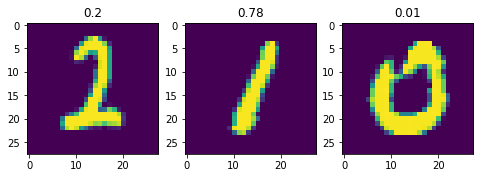

Bag number: 6


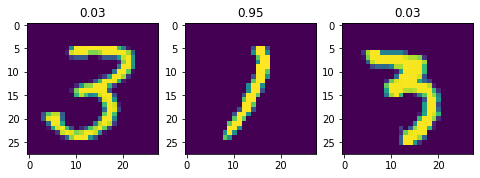

Bag number: 7


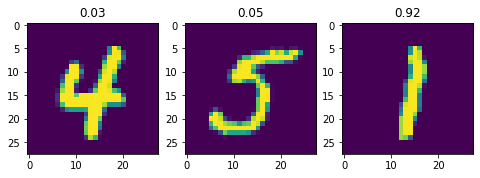

In [16]:
plot(
    val_data,
    val_labels,
    "positive",
    predictions=class_predictions,
    attention_weights=attention_params,
)

The bag class label is negative
Bag number: 0


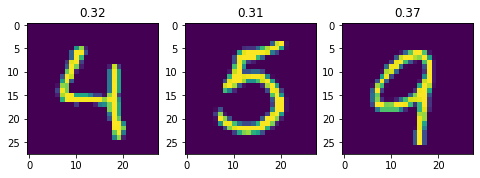

Bag number: 1


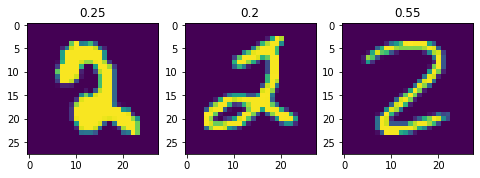

Bag number: 3


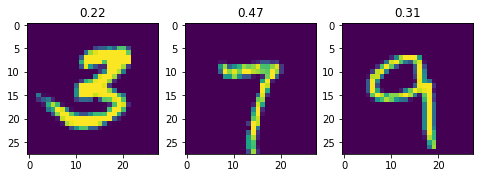

In [17]:
plot(
    val_data,
    val_labels,
    "negative",
    predictions=class_predictions,
    attention_weights=attention_params,
)

--------------

## Conclusion
From the above plot, you can notice that the weights always sum to 1. In a positively predict bag, the instance which resulted in the positive labeling will have a substantially higher attention score than the rest of the bag. However, in a negatively predicted bag, there are two cases:  
从上图中可以发现，注意力权重总和始终为1，在正包中，正实例的权重要远远高于其他实例；在负包中存在以下两个现象：  
* All instances will have approximately similar scores. 
* 所有实例权重分布大致相同。
* An instance will have relatively higher score (but not as high as of a positive instance). This is because the feature space of this instance is close to that of the positive instance. 
* 所有实例都有较高的得分（相对于正包中的负实例而言），这是因为实例的特征空间与正实例的特征空间非常接近（MNIST数据集的样本风格基本一致，可以说画风很相似）。

------------

## Remarsk
* If the model is overfit, the weights will be equally distributed for all bags. Hence, the regularization techniques are necessary.
* 如果模型过拟合了，那么就不要对权重进行重分配。
* In the paper, the bag sizes can differ from one bag to another. For simplicity, the bag sizes are fixed here.
* 在原始论文中，包的尺寸是非固定的，这里为了简化将所有包的大小都固定成一个值。
* In order not to rely on the random initial weights of a single model, averaging ensemble methods should be considered.
* 为了让性能不依赖于某一个模型的随机初始权重，可以考虑使用均值集成方法（averaging ensembel method）。

关于模型集成可以参考知乎博主 **AlphaJia** 的博客 [模型集成(Model Ensemble)](https://zhuanlan.zhihu.com/p/269215725) 了解一个大致的概念，后面会有例子演示什么是模型集成。